# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

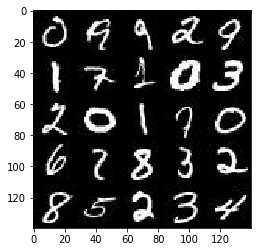

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

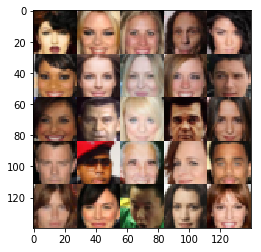

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        h1 = tf.nn.dropout(h1, 0.9)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        h2 = tf.nn.dropout(h2, 0.8)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        h3 = tf.nn.dropout(h3, 0.8)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        output = tf.tanh(logits)
    
        return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    g_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7329... Generator Loss: 0.2305
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 1.3066
Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 0.9288
Epoch 1/2... Discriminator Loss: 0.5370... Generator Loss: 5.5023
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 2.5094
Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 2.2210
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 4.4884
Epoch 1/2... Discriminator Loss: 2.0378... Generator Loss: 10.7892
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 1.4392
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 3.6314


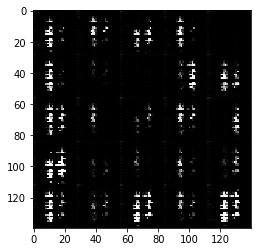

Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 0.6721... Generator Loss: 1.9188
Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 2.2420
Epoch 1/2... Discriminator Loss: 2.7656... Generator Loss: 0.2083
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 3.4969
Epoch 1/2... Discriminator Loss: 1.5250... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 0.5116... Generator Loss: 2.7484
Epoch 1/2... Discriminator Loss: 0.7025... Generator Loss: 2.7661


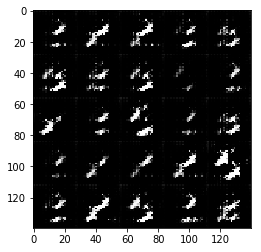

Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 2.3336
Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 2.7272
Epoch 1/2... Discriminator Loss: 0.5129... Generator Loss: 3.7283
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 4.4454
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 1.8497
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 2.5994


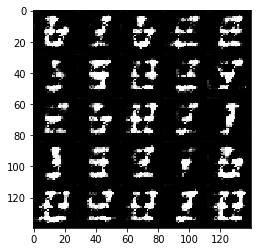

Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.6062
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.7190
Epoch 1/2... Discriminator Loss: 0.7806... Generator Loss: 1.6750
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.5174
Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 1.9247
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 2.1947
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.0876
Epoch 1/2... Discriminator Loss: 1.5801... Generator Loss: 4.1100
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 1.2399
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 0.6592


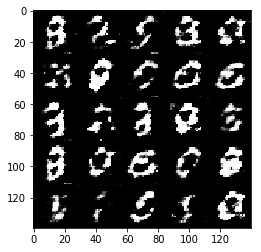

Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 2.0307
Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 2.3002
Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 2.1123... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.4069
Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 1.9157
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.1308
Epoch 1/2... Discriminator Loss: 0.7656... Generator Loss: 1.6116
Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 1.4307


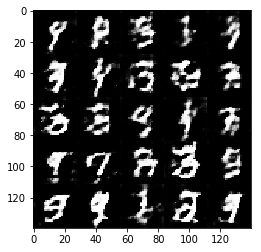

Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 1.1954
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 1.0743
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 1.3273
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 1.2474
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 1.7955
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 1.3665
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.8852
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 1.7896
Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 1.9183


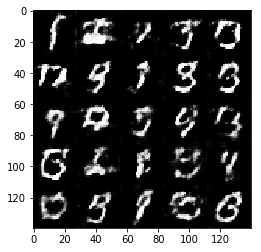

Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 1.8837
Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 1.8652
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 1.7957
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 3.1754


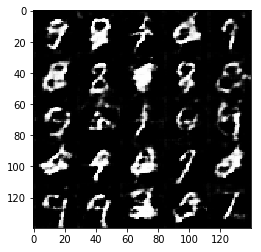

Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 1.8064
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 1.0028
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.7410
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 1.7300
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 2.3579
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 1.5601
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.9653


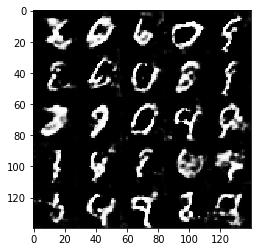

Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 2.1687
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.3137
Epoch 1/2... Discriminator Loss: 1.6609... Generator Loss: 2.5818
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 1.2863
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 2.4867
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 1.4508
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.7660
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.9964


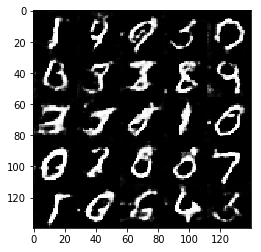

Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.5452
Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.6026
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.8225
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 1.9698
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 2.2912
Epoch 2/2... Discriminator Loss: 1.2978... Generator Loss: 2.0045
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.8758
Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 0.9555
Epoch 2/2... Discriminator Loss: 1.0943... Generator Loss: 1.2460


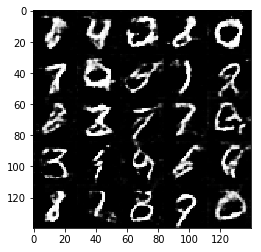

Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.4440
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 1.4923
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 1.0549
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 3.0773
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.1994
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 1.3851


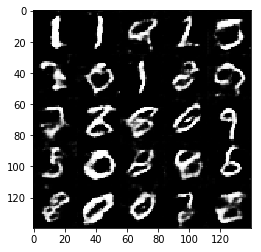

Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 1.7862
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 1.4527
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.6006
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 1.0024
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 1.1071
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 1.6868
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.6103
Epoch 2/2... Discriminator Loss: 1.8783... Generator Loss: 0.3353


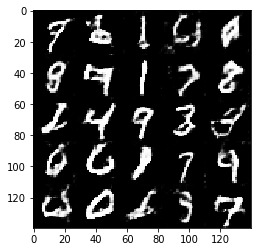

Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.0881
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 2.7029
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.5055
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 1.9084
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 1.6318
Epoch 2/2... Discriminator Loss: 1.7684... Generator Loss: 2.4831
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.7389


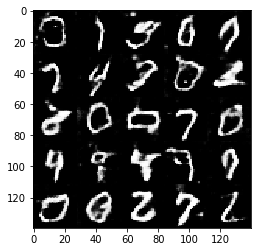

Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.6754
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 1.1058
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.0046
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 1.5590
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 1.1890


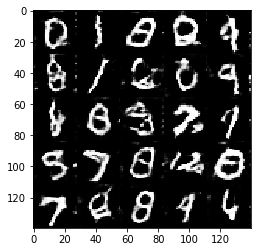

Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 2.1374
Epoch 2/2... Discriminator Loss: 1.9270... Generator Loss: 0.3158
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 1.0601
Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.4412
Epoch 2/2... Discriminator Loss: 0.8151... Generator Loss: 1.6246
Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 1.0003... Generator Loss: 1.6466
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.6453


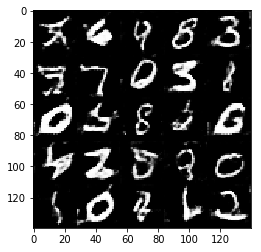

Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 1.1424
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.9926
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.5805
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.3726
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 1.7677
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 1.9068
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.7163
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 1.6003


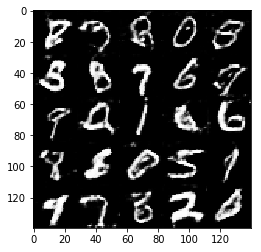

Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.7672
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.1525
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 2.2363
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 1.6879
Epoch 2/2... Discriminator Loss: 1.2220... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 2.2714
Epoch 2/2... Discriminator Loss: 1.8595... Generator Loss: 0.3383
Epoch 2/2... Discriminator Loss: 1.1066... Generator Loss: 1.1608


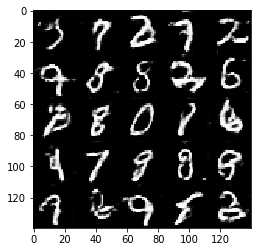

Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.4314
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.1003... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.3504
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 1.1097
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.7509


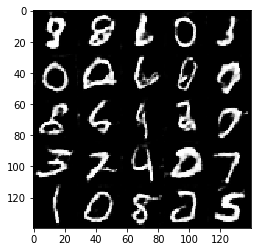

Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 1.7410
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 1.1805... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 1.8617
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 1.6773
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.1280


In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.9321... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 2.7908
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 3.2065
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.7609
Epoch 1/1... Discriminator Loss: 2.8976... Generator Loss: 7.1874
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.7909
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 4.1518
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.6884
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 2.5971
Epoch 1/1... Discriminator Loss: 4.1440... Generator Loss: 8.5606


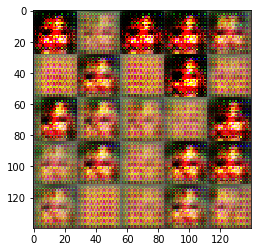

Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 2.5080
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 2.7576
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 5.0036
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 8.6664
Epoch 1/1... Discriminator Loss: 2.3429... Generator Loss: 7.1603
Epoch 1/1... Discriminator Loss: 2.4284... Generator Loss: 6.9018
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 4.9900
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.8163
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.3663


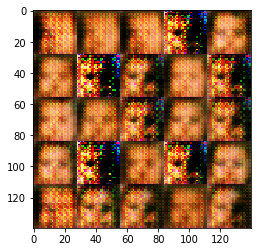

Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.7916
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 2.5573
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.3622
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.9504
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.4992


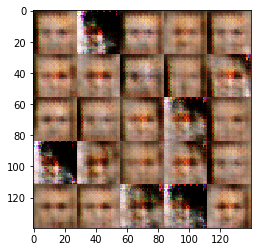

Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.7188... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.1027


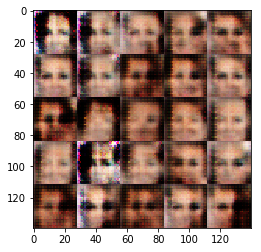

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 1.6731
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 2.0877... Generator Loss: 2.9543
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 1.6835
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.9516


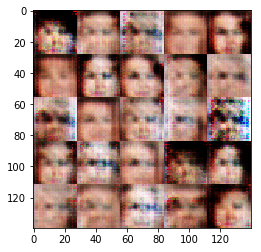

Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.9530
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 2.0131... Generator Loss: 2.5533
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 1.8228
Epoch 1/1... Discriminator Loss: 1.6671... Generator Loss: 2.3073
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.5238
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.4508


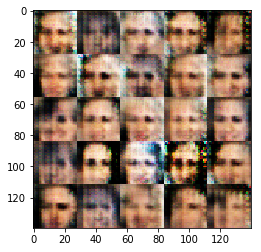

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 2.1124
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.8836... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.9230... Generator Loss: 2.5001
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 2.3296
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 1.8784


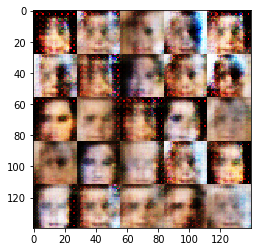

Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.8783
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.2980


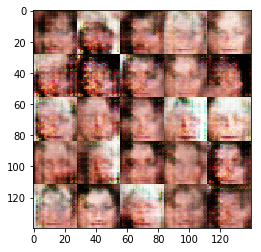

Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 1.6885
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.4840
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.9604... Generator Loss: 0.3028


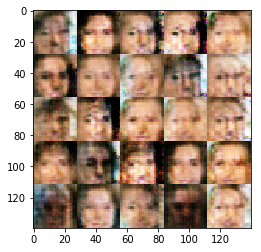

Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.2477
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 2.4155
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.4723
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.6502


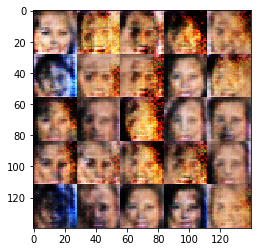

Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 1.2052
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 2.5390
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.4352


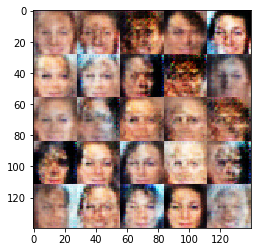

Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 2.2688
Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 2.1443
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.4571


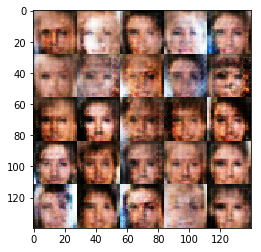

Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.3925
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 2.2108... Generator Loss: 3.3547
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6346


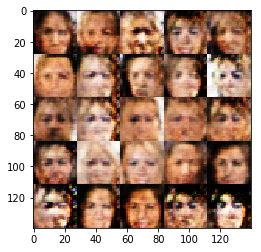

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.5323
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 2.0953
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.9466
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.8683


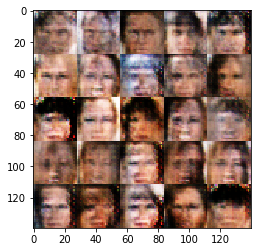

Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.6543


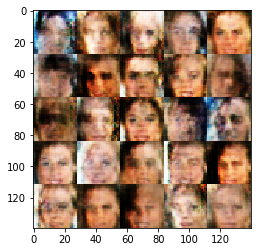

Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.8140
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 2.5309
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.6916


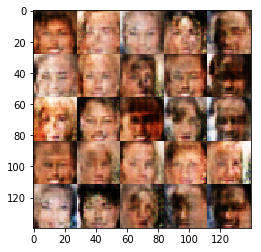

Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 1.7100
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7524


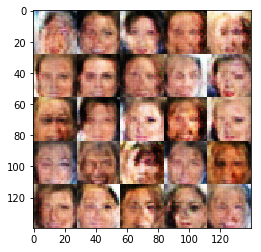

Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 2.4468
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 1.9320
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.6805


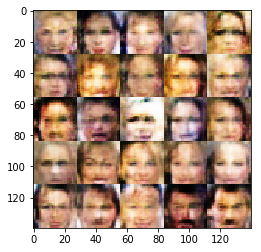

Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.5726
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 2.2125
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.6655
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.1236


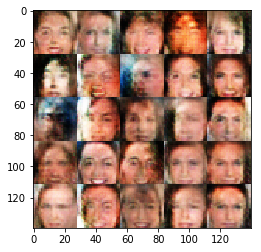

Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.6012
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.0356


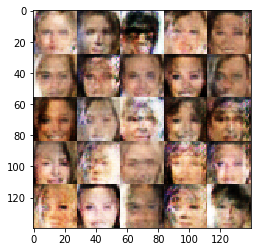

Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.8779
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.1342


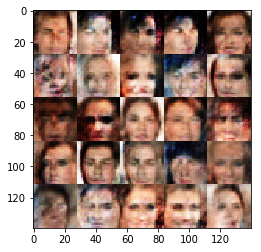

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 2.2387
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 0.8393


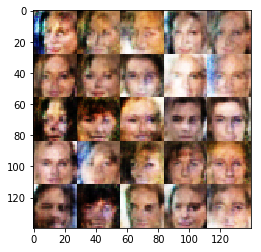

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.9392
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 2.2936
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.5516


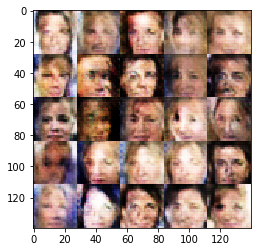

Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 1.7450
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.3739
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 2.2343
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.9459


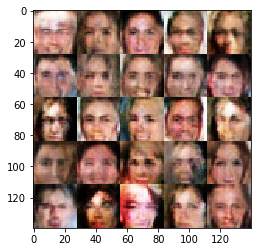

Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.1464


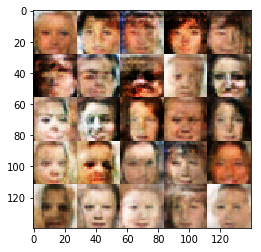

Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 1.8866
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.3126


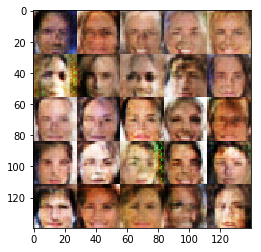

Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.3049
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.0404


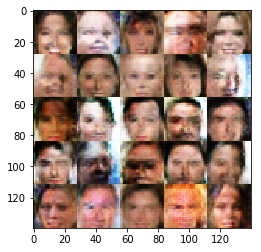

Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.8422


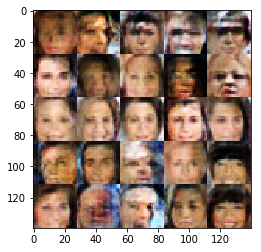

Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.6094
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.8005
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.5440


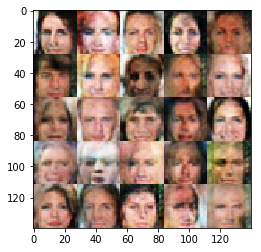

Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.4809
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 2.3646... Generator Loss: 0.2074


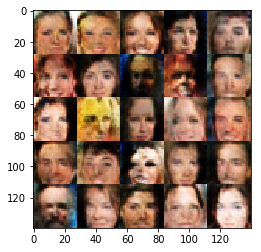

Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.9966
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.3893


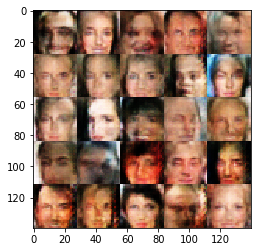

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0995


In [38]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.